In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import tensorflow
import parquet
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_percentage_error , mean_absolute_error , mean_squared_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [2]:
#!pip install pandasql
#!pip install tensorflow
#!pip install parquet
#!pip install Scikit-learn

# DATA PREPARATION

# START TRAINING FROM HERE

In [4]:
df = pd.read_parquet('kelusanka_2022_after imputing_missing.parquet')
len(df)

4745

In [5]:
hourly_train,hourly_test = df[['DEMAND']].iloc[:4342],df[['DEMAND']].iloc[4342:]
#hourly_train,hourly_test
print(len(hourly_train),len(hourly_test))

4342 403


In [6]:
scaler = MinMaxScaler()
scaler.fit(hourly_train)
scaled_hourly_train = scaler.transform(hourly_train)
scaled_hourly_test = scaler.transform(hourly_test)
len(scaled_hourly_train)

4342

In [7]:
scaled_hourly_train

array([[0.11637931],
       [0.29741379],
       [0.09051724],
       ...,
       [0.56465517],
       [0.60775862],
       [0.06465517]])

In [8]:
n_input_hourly = 4
n_features = 1
def train_data_hourly(a,n):
    R,s=[],[]
    for i in range(len(scaled_hourly_train)):
        end_ix = i + n_input_hourly
        if end_ix > len(scaled_hourly_train)-1:
            break
        seq_r,seq_s = scaled_hourly_train[i:end_ix],scaled_hourly_train[end_ix]
        R.append(seq_r)
        s.append(seq_s)
    return np.array(R),np.array(s)
R,s = train_data_hourly(scaled_hourly_train,n_input_hourly)
R_train,R_val,s_train,s_val =train_test_split(R,s,test_size=0.15,shuffle = False,random_state = 0)

In [9]:
### defining hourly model
model1 =Sequential()
model1.add(LSTM(128,activation ='relu',input_shape=(n_input_hourly,n_features),return_sequences=True))#return sequence when more than one layer
#return sequence is used for first two layers to ensure that the output of each layer is fed into the next layer
#in the sequence
##model1.add(Dropout(0.2))
#Droupout regularization is used for preventing overfitting in LSTM layers
model1.add(LSTM(64,return_sequences=True))
##model1.add(Dropout(0.2))
model1.add(LSTM(16))
model1.add(Dense(1))

In [10]:
#model compiling
model1.compile(optimizer = 'adam',loss = 'mse')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 4, 64)             49408     
                                                                 
 lstm_2 (LSTM)               (None, 16)                5184      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 121,169
Trainable params: 121,169
Non-trainable params: 0
_________________________________________________________________


In [17]:
model1.fit(R,s, epochs=120 ,batch_size = 32 )

In [11]:
model1 = load_model('kelu_2022_best.h5')
#25 mape 120 epoch n_input_hourly = 4, batch_size = 32

In [12]:
model1.evaluate(R,s,verbose = 2)

136/136 - 1s - loss: 0.0090 - 1s/epoch - 10ms/step


0.009024569764733315

# HOURLY TESTING BY PREDICTION

In [13]:
#output test
last_train_batch = scaled_hourly_train[-n_input_hourly:]
last_train_batch = last_train_batch.reshape(1,n_input_hourly,n_features)
last_train_batch,model1.predict(last_train_batch)

1/1 [==============================] - 1s 939ms/step


(array([[[0.48706897],
         [0.56465517],
         [0.60775862],
         [0.06465517]]]),
 array([[0.22881445]], dtype=float32))

In [14]:
scaled_hourly_test[0]

array([0.26293103])

In [15]:
hourly_predictions = []
first_eval_batch = scaled_hourly_train[-n_input_hourly:]
current_batch = first_eval_batch.reshape(1,n_input_hourly,n_features)

for i in range(len(scaled_hourly_test)):
    # get the prediction value for first batch
    current_pred = model1.predict(current_batch)[0]
    
    # appending the prediction into array
    hourly_predictions.append(current_pred)
    
    #updating the batch with the predicted value and removing the first element
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)
    
#hourly_predictions

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


In [16]:
scaled_hourly_test1 = scaler.inverse_transform(scaled_hourly_test)
scaled_hourly_test2 = pd.DataFrame(scaled_hourly_test1)
true_predictions = scaler.inverse_transform(hourly_predictions)
scaled_hourly_test2['predictions'] = np.round(true_predictions)
scaled_hourly_test2

,0,predictions
0,62.0,54.0
1,162.0,141.0
2,63.0,61.0
3,26.0,32.0
4,59.0,63.0
...,...,...
398,75.0,74.0
399,90.0,112.0
400,106.0,125.0
401,138.0,110.0


rmse: 23.31960484706645
mape: 25.460489233562477
wmape: 22.183813269060003


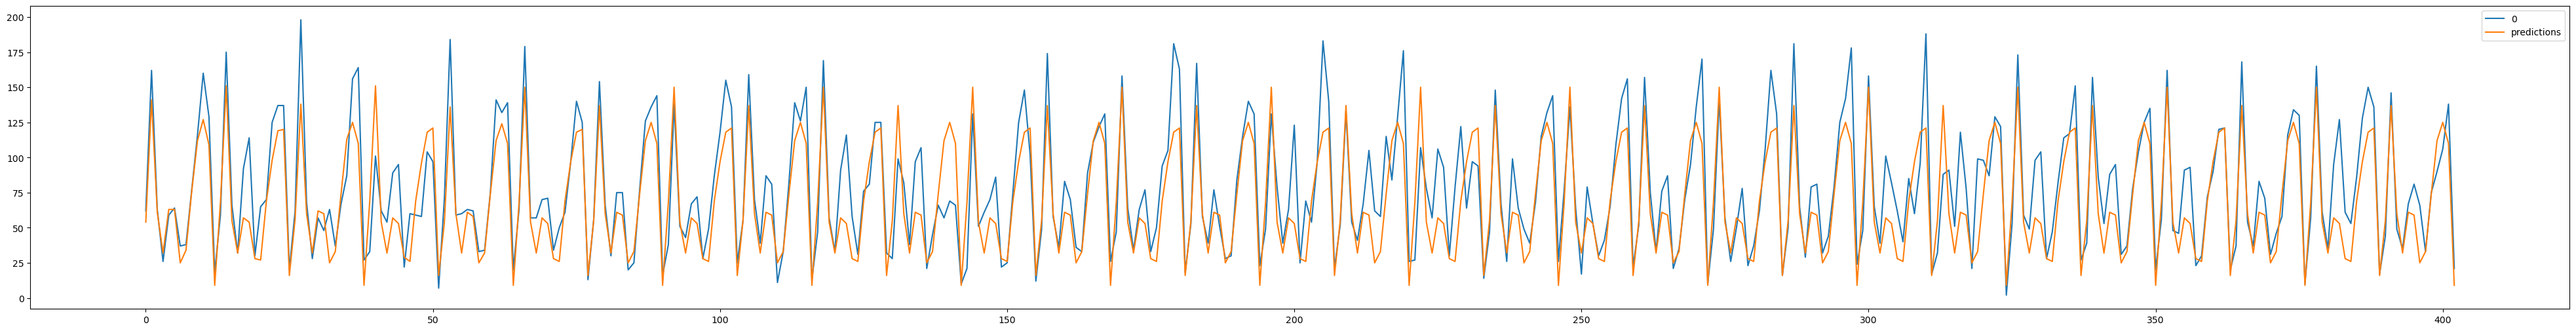

In [17]:
scaled_hourly_test2.plot(kind = 'line',figsize =(50,6))
rmse = sqrt(mean_squared_error(scaled_hourly_test2[0],scaled_hourly_test2['predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(scaled_hourly_test2))*np.sum(np.abs((scaled_hourly_test2[0]-scaled_hourly_test2['predictions'])/scaled_hourly_test2[0]))*100
print('mape:',mape)
wmape = np.sum((scaled_hourly_test2[0]/np.sum(scaled_hourly_test2[0]))*(np.abs((scaled_hourly_test2[0]-scaled_hourly_test2['predictions'])/scaled_hourly_test2[0])))*100
print('wmape:',wmape)

In [209]:
print('mape: ',mean_absolute_percentage_error(scaled_hourly_test2['actuals'],scaled_hourly_test2['predictions']))

mape:  0.2546048923356248


In [45]:
#model1.save('kelu_2022_best.h5')
#25 mape 120 epoch n_input_hourly = 4, batch_size = 25

# DAILY PERIODICITY

In [18]:
n_input_daily = 7
n_features = 1
def daily_train_data(a,n):
    X,y=[],[]
    for i in range(len(a)-13):
        end_ix = i +13*n
        if end_ix > len(a)-1:
            break
        seq_x,seq_y = [a[i+13*j] for j in range(n)],a[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)
X,y = daily_train_data(scaled_hourly_train,n_input_daily)

In [19]:
X[0],y[0]

(array([[0.11637931],
        [0.08189655],
        [0.44396552],
        [0.34913793],
        [0.38362069],
        [0.43103448],
        [0.4137931 ]]),
 array([0.0387931]))

In [20]:
len(X),len(y),X.shape

(4251, 4251, (4251, 7, 1))

In [21]:
X_train,X_val,y_train,y_val =train_test_split(X,y,test_size=0.2,shuffle = False,random_state = 0)
len(X_train),len(X_val),len(y_train),len(y_val)

(3400, 851, 3400, 851)

In [31]:
### defining daily model
model2 =Sequential()
model2.add(LSTM(128,activation ='relu',input_shape=(n_input_daily,n_features),return_sequences=True))#return sequence when more than one layer
##model2.add(Dropout(0.2))
model2.add(LSTM(64,return_sequences=True))
##model2.add(Dropout(0.2))
model2.add(LSTM(16))
model2.add(Dense(1))

In [32]:
#model compiling
model2.compile(optimizer = 'adam',loss = 'mse')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 128)            66560     
                                                                 
 lstm_7 (LSTM)               (None, 7, 64)             49408     
                                                                 
 lstm_8 (LSTM)               (None, 16)                5184      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 121,169
Trainable params: 121,169
Non-trainable params: 0
_________________________________________________________________


In [57]:
model2.fit(X,y,epochs =230,batch_size = 100)

In [99]:
model2 = load_model('daily_training.h5')
#22% mape 230 epochs,n_input_daily=7,batch_size = 100

# Daily periodicity prediction

In [47]:
first_prediction_set = scaled_hourly_train[len(X):]
#first_prediction_set

In [48]:
def training_batch(a):
    first_predict_batch = []
    for i in range(n_input_daily):
        first_predict_batch.append(list(a[13*i]))
    first_predict_batch =np.array(first_predict_batch)
    return first_predict_batch

In [49]:
daily_predictions = []
train_batch = training_batch(first_prediction_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)

for i in range(len(scaled_hourly_test)):
    # get the prediction value for first batch
    current_pred = model2.predict(current_batch)[0]
    
    # appending the prediction into array
    daily_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    first_prediction_set = np.append(first_prediction_set[1:],current_pred)
    updated_prediction_set = first_prediction_set[:, np.newaxis]
    train_batch = training_batch(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)
    
#daily_predictions

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


In [50]:
scaled_daily_test1 = scaler.inverse_transform(scaled_hourly_test)
scaled_daily_test2 = pd.DataFrame(scaled_daily_test1)
true_predictions = scaler.inverse_transform(daily_predictions)
scaled_daily_test2['predictions'] = np.round(true_predictions)
scaled_daily_test2

,0,predictions
0,62.0,61.0
1,162.0,163.0
2,63.0,76.0
3,26.0,38.0
4,59.0,77.0
...,...,...
398,75.0,57.0
399,90.0,88.0
400,106.0,114.0
401,138.0,122.0


rmse: 19.646630103956436
mape: 22.882783685214747
wmape: 18.77457820626665


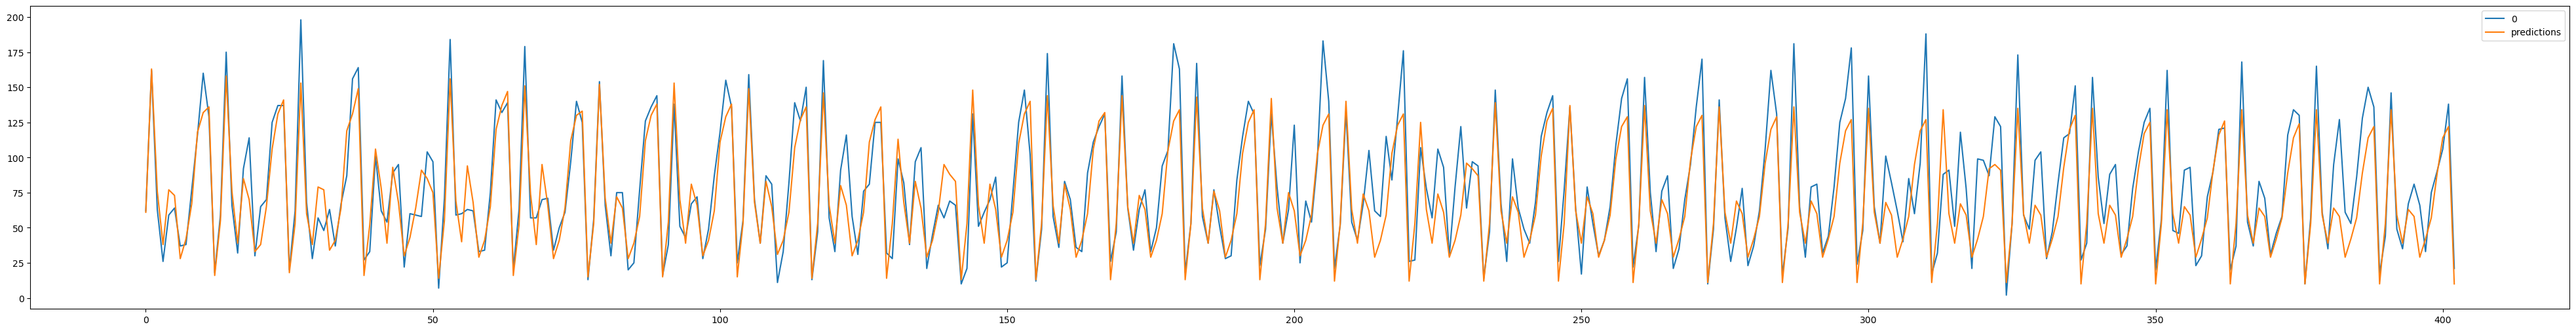

In [51]:
scaled_daily_test2.plot(kind = 'line',figsize =(50,6))

rmse = sqrt(mean_squared_error(scaled_daily_test2[0],scaled_daily_test2['predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(scaled_daily_test2))*np.sum(np.abs((scaled_daily_test2[0]-scaled_daily_test2['predictions'])/scaled_daily_test2[0]))*100
print('mape:',mape)
wmape = np.sum((scaled_daily_test2[0]/np.sum(scaled_daily_test2[0]))*(np.abs((scaled_daily_test2[0]-scaled_daily_test2['predictions'])/scaled_daily_test2[0])))*100
print('wmape:',wmape)

In [39]:
#model2.save('daily_training.h5')

# WEEKLY TREND CHARECTERISTICS

In [52]:
n_input_weekly = 6
n_features = 1
def weekly_train_data(a,n):
    U,v=[],[]
    for i in range(len(a)-91):
        end_ix = i +91*n
        if end_ix > len(a)-1:
            break
        seq_u,seq_v = [a[i+91*j] for j in range(n)],a[end_ix]
        U.append(seq_u)
        v.append(seq_v)
    return np.array(U),np.array(v)
U,v = weekly_train_data(scaled_hourly_train,n_input_weekly)
U_train,U_val,v_train,v_val =train_test_split(U,v,test_size=0.15,shuffle = False,random_state = 0)

In [53]:
U[0],v[0]

(array([[0.11637931],
        [0.0387931 ],
        [0.13362069],
        [0.37068966],
        [0.32758621],
        [0.40086207]]),
 array([0.28448276]))

In [72]:
model3 =Sequential()
model3.add(LSTM(128,activation ='relu',input_shape=(n_input_weekly,n_features),return_sequences=True))#return sequence when more than one layer
##model3.add(Dropout(0.2))
model3.add(LSTM(64,return_sequences=True))
##model3.add(Dropout(0.2))
model3.add(LSTM(16))
model3.add(Dense(1))

In [73]:
#model compiling
model3.compile(optimizer = 'adam',loss = 'mse')
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 6, 128)            66560     
                                                                 
 lstm_16 (LSTM)              (None, 6, 64)             49408     
                                                                 
 lstm_17 (LSTM)              (None, 16)                5184      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 121,169
Trainable params: 121,169
Non-trainable params: 0
_________________________________________________________________


In [66]:
model3.fit(U,v,epochs = 100,batch_size = 50)

Epoch 1/100
38/38 [==============================] - 5s 23ms/step - loss: 0.0294
Epoch 2/100
38/38 [==============================] - 1s 22ms/step - loss: 0.0079
Epoch 3/100
38/38 [==============================] - 1s 30ms/step - loss: 0.0074
Epoch 4/100
38/38 [==============================] - 1s 39ms/step - loss: 0.0072
Epoch 5/100
38/38 [==============================] - 1s 31ms/step - loss: 0.0071
Epoch 6/100
38/38 [==============================] - 1s 19ms/step - loss: 0.0072
Epoch 7/100
38/38 [==============================] - 1s 20ms/step - loss: 0.0070
Epoch 8/100
38/38 [==============================] - 1s 22ms/step - loss: 0.0070
Epoch 9/100
38/38 [==============================] - 1s 21ms/step - loss: 0.0072
Epoch 10/100
38/38 [==============================] - 1s 31ms/step - loss: 0.0070
Epoch 11/100
38/38 [==============================] - 1s 20ms/step - loss: 0.0069
Epoch 12/100
38/38 [==============================] - 1s 24ms/step - loss: 0.0068
Epoch 13/100
38/38 [=====

In [74]:
model3 = load_model('weekly_training.h5')
#19% mape, epochs 100,batch_size= 50, n_input_weekly=6,rmse 17

In [58]:
len(U),len(v),U.shape

(3796, 3796, (3796, 6, 1))

# WEEKLY PREDICTION

In [75]:
weekly_prediction_set = scaled_hourly_train[len(U):]
#weekly_prediction_set

In [76]:
def training_batch_weekly(a):
    first_predict_batch = []
    for i in range(n_input_weekly):
        first_predict_batch.append(list(a[91*i]))
    first_predict_batch =np.array(first_predict_batch)
    return first_predict_batch

In [77]:
weekly_predictions = []
train_batch = training_batch_weekly(weekly_prediction_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)

for i in range(len(scaled_hourly_test)):
    # get the prediction value for first batch
    current_pred = model3.predict(current_batch)[0]
    
    # appending the prediction into array
    weekly_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    weekly_prediction_set = np.append(weekly_prediction_set[1:],current_pred)
    updated_prediction_set = weekly_prediction_set[:, np.newaxis]
    train_batch = training_batch_weekly(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)
    
#weekly_predictions

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


In [78]:
scaled_weekly_test1 = scaler.inverse_transform(scaled_hourly_test)
scaled_weekly_test2 = pd.DataFrame(scaled_weekly_test1)
true_predictions = scaler.inverse_transform(weekly_predictions)
scaled_weekly_test2['predictions'] = np.round(true_predictions)
scaled_weekly_test2

,0,predictions
0,62.0,74.0
1,162.0,147.0
2,63.0,64.0
3,26.0,33.0
4,59.0,62.0
...,...,...
398,75.0,64.0
399,90.0,94.0
400,106.0,129.0
401,138.0,126.0


rmse: 17.402546803147292
mape: 19.807361863221406
wmape: 16.497526322466065


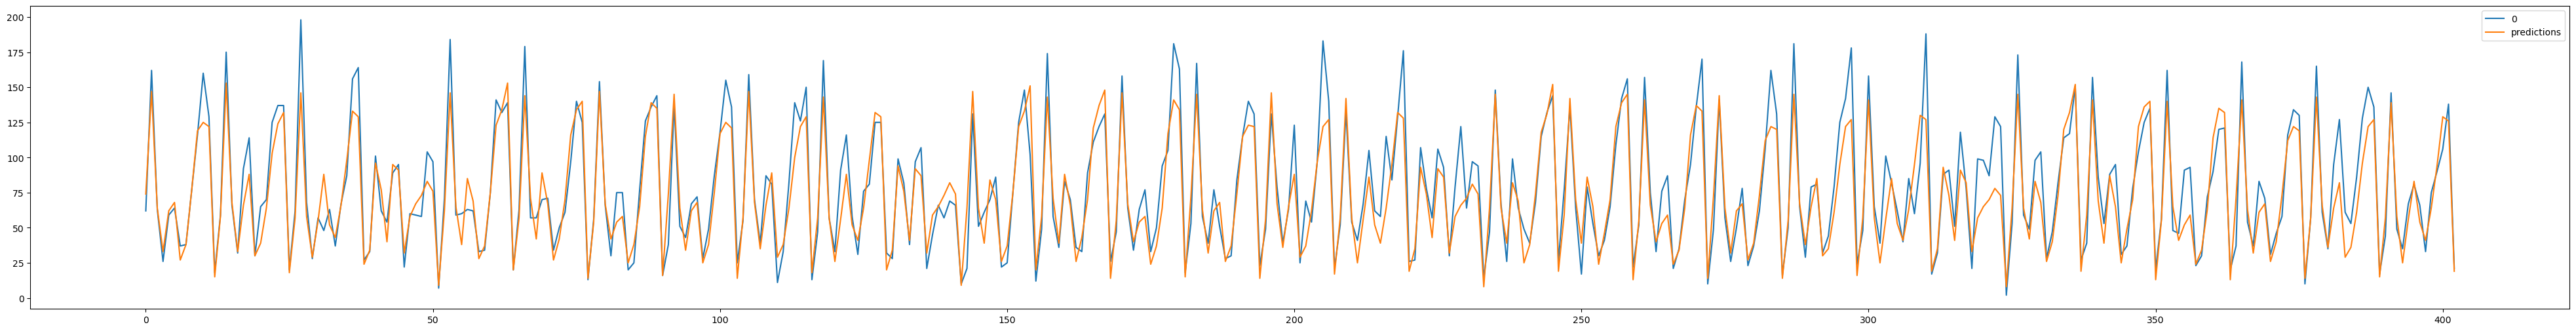

In [79]:
scaled_weekly_test2.plot(kind = 'line',figsize =(50,6))

rmse = sqrt(mean_squared_error(scaled_weekly_test2[0],scaled_weekly_test2['predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(scaled_weekly_test2))*np.sum(np.abs((scaled_weekly_test2[0]-scaled_weekly_test2['predictions'])/scaled_weekly_test2[0]))*100
print('mape:',mape)
wmape = np.sum((scaled_weekly_test2[0]/np.sum(scaled_weekly_test2[0]))*(np.abs((scaled_weekly_test2[0]-scaled_weekly_test2['predictions'])/scaled_weekly_test2[0])))*100
print('wmape:',wmape)

In [67]:
#model3.save('weekly_training.h5')

In [80]:
scaled_hourly_test2 = scaled_hourly_test2.rename(columns = {0:'actuals'})
scaled_daily_test2 = scaled_daily_test2.rename(columns = {0:'actuals'})
scaled_weekly_test2 = scaled_weekly_test2.rename(columns = {0:'actuals'})

In [81]:
scaled_hourly_test2.to_parquet('predictions and actuals_hourly.parquet')
scaled_daily_test2.to_parquet('predictions and actuals_daily.parquet')
scaled_weekly_test2.to_parquet('predictions and actuals-weekly.parquet')

# FUSING BY STACKING
## USING NEURAL NETWORKS

In [82]:
hourly_preds = pd.read_parquet('predictions and actuals_hourly.parquet')
daily_preds = pd.read_parquet('predictions and actuals_daily.parquet')
weekly_preds = pd.read_parquet('predictions and actuals-weekly.parquet')

In [83]:
mean_squared_error(hourly_preds['actuals'],hourly_preds['predictions'])

543.8039702233251

In [84]:
##using performance weightage in weighted average method
ensemble_predictions = (0.15*hourly_preds['predictions'] + 0.15*daily_preds['predictions'] + 0.7*weekly_preds['predictions'])

In [85]:
rmse = sqrt(mean_squared_error(hourly_preds['actuals'],ensemble_predictions))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(hourly_preds))*np.sum(np.abs((hourly_preds['actuals']-ensemble_predictions)/hourly_preds['actuals']))*100
print('mape:',mape)
wmape = np.sum((hourly_preds['actuals']/np.sum(hourly_preds['actuals']))*(np.abs((hourly_preds['actuals']-ensemble_predictions)/hourly_preds['actuals'])))*100
print('wmape:',wmape)

rmse: 17.607951163287982
mape: 19.966093118656097
wmape: 16.64166560953952


In [86]:
X_train,X_val = hourly_train[['DEMAND']].iloc[:3952],hourly_train[['DEMAND']].iloc[3952:]

In [87]:
X_train,X_val = scaler.transform(X_train),scaler.transform(X_val)

In [88]:
len(X_train)-65

3887

In [89]:
val_predictions = []
first_eval_batch = X_train[-n_input_hourly:]
current_batch = first_eval_batch.reshape(1,n_input_hourly,n_features)

for i in range(len(X_val)):
    # get the prediction value for first batch
    current_pred = model1.predict(current_batch)[0]
    
    # appending the prediction into array
    val_predictions.append(current_pred)
    
    #updating the batch with the predicted value and removing the first element
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)
    
val_predictions

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step


[array([0.25164914], dtype=float32),
 array([0.63827634], dtype=float32),
 array([0.26586556], dtype=float32),
 array([0.1391958], dtype=float32),
 array([0.27556682], dtype=float32),
 array([0.283086], dtype=float32),
 array([0.09824802], dtype=float32),
 array([0.14508906], dtype=float32),
 array([0.33376908], dtype=float32),
 array([0.49447384], dtype=float32),
 array([0.54531443], dtype=float32),
 array([0.47061828], dtype=float32),
 array([0.0340189], dtype=float32),
 array([0.29911196], dtype=float32),
 array([0.64992106], dtype=float32),
 array([0.22931367], dtype=float32),
 array([0.13298933], dtype=float32),
 array([0.23868512], dtype=float32),
 array([0.22554824], dtype=float32),
 array([0.12277431], dtype=float32),
 array([0.10841817], dtype=float32),
 array([0.2868072], dtype=float32),
 array([0.4027141], dtype=float32),
 array([0.5060823], dtype=float32),
 array([0.52405167], dtype=float32),
 array([0.06290209], dtype=float32),
 array([0.22371161], dtype=float32),
 array([

In [90]:
val_test1 = scaler.inverse_transform(X_val)
val_test2 = pd.DataFrame(val_test1)
true_predictions = scaler.inverse_transform(val_predictions)
val_test2['val_predictions'] = np.round(true_predictions)
val_test2

,0,val_predictions
0,48.0,59.0
1,144.0,149.0
2,57.0,63.0
3,42.0,33.0
4,59.0,65.0
...,...,...
385,45.0,69.0
386,114.0,97.0
387,132.0,118.0
388,142.0,121.0


In [91]:
rmse = sqrt(mean_squared_error(val_test2[0],val_test2['val_predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(val_test2))*np.sum(np.abs((val_test2[0]-val_test2['val_predictions'])/val_test2[0]))*100
print('mape:',mape)
wmape = np.sum((val_test2[0]/np.sum(val_test2[0]))*(np.abs((val_test2[0]-val_test2['val_predictions'])/val_test2[0])))*100
print('wmape:',wmape)

rmse: 22.954637540492435
mape: 24.811042622163804
wmape: 21.415478615071283


In [101]:
val_prediction_set = X_train[len(X_train)-91:]
#val_prediction_set

In [102]:
daily_val_predictions = []
train_batch = training_batch(val_prediction_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)

for i in range(len(X_val)):
    # get the prediction value for first batch
    current_pred = model2.predict(current_batch)[0]
    
    # appending the prediction into array
    daily_val_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    val_prediction_set = np.append(val_prediction_set[1:],current_pred)
    updated_prediction_set = val_prediction_set[:, np.newaxis]
    train_batch = training_batch(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_daily,n_features)
    
#daily_val_predictions

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


In [103]:
val_daily_test1 = scaler.inverse_transform(X_val)
val_daily_test2 = pd.DataFrame(val_daily_test1)
true_predictions = scaler.inverse_transform(daily_val_predictions)
val_daily_test2['val_predictions'] = np.round(true_predictions)
val_daily_test2

,0,val_predictions
0,48.0,53.0
1,144.0,115.0
2,57.0,61.0
3,42.0,45.0
4,59.0,70.0
...,...,...
385,45.0,58.0
386,114.0,80.0
387,132.0,97.0
388,142.0,83.0


In [104]:
rmse = sqrt(mean_squared_error(val_daily_test2[0],val_daily_test2['val_predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(val_daily_test2))*np.sum(np.abs((val_daily_test2[0]-val_daily_test2['val_predictions'])/val_daily_test2[0]))*100
print('mape:',mape)
wmape = np.sum((val_daily_test2[0]/np.sum(val_daily_test2[0]))*(np.abs((val_daily_test2[0]-val_daily_test2['val_predictions'])/val_daily_test2[0])))*100
print('wmape:',wmape)

rmse: 25.55757702893104
mape: 26.281127450734882
wmape: 23.733876442634077


In [96]:
val_weekly_pred_set = X_train[len(X_train)-546:]
#val_weekly_pred_set

In [97]:
weekly_val_predictions = []
train_batch = training_batch_weekly(val_weekly_pred_set)
first_eval_batch1 = train_batch
current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)

for i in range(len(X_val)):
    # get the prediction value for first batch
    current_pred = model3.predict(current_batch)[0]
    
    # appending the prediction into array
    weekly_val_predictions.append(current_pred)
    #updating the batch with the predicted value and removing the first element
    val_weekly_pred_set = np.append(val_weekly_pred_set[1:],current_pred)
    updated_prediction_set = val_weekly_pred_set[:, np.newaxis]
    train_batch = training_batch_weekly(updated_prediction_set)
    first_eval_batch1 = train_batch
    current_batch = first_eval_batch1.reshape(1,n_input_weekly,n_features)
    
#weekly_val_predictions

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


In [98]:
val_weekly_test1 = scaler.inverse_transform(X_val)
val_weekly_test2 = pd.DataFrame(val_weekly_test1)
true_predictions = scaler.inverse_transform(weekly_val_predictions)
val_weekly_test2['val_predictions'] = np.round(true_predictions)
val_weekly_test2

,0,val_predictions
0,48.0,53.0
1,144.0,135.0
2,57.0,67.0
3,42.0,50.0
4,59.0,72.0
...,...,...
385,45.0,72.0
386,114.0,79.0
387,132.0,111.0
388,142.0,112.0


In [100]:
rmse = sqrt(mean_squared_error(val_weekly_test2[0],val_weekly_test2['val_predictions']))
print('rmse:',rmse)
#MAPE should be less than 10
mape = (1/len(val_weekly_test2))*np.sum(np.abs((val_weekly_test2[0]-val_weekly_test2['val_predictions'])/val_weekly_test2[0]))*100
print('mape:',mape)
wmape = np.sum((val_weekly_test2[0]/np.sum(val_weekly_test2[0]))*(np.abs((val_weekly_test2[0]-val_weekly_test2['val_predictions'])/val_weekly_test2[0])))*100
print('wmape:',wmape)

rmse: 22.24375452536319
mape: 23.560748734653387
wmape: 20.319076714188732


In [105]:
hourly_val_preds = scaler.transform(val_test2[['val_predictions']])
daily_val_preds = scaler.transform(val_daily_test2[['val_predictions']])
weekly_val_preds = scaler.transform(val_weekly_test2[['val_predictions']])

C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- val_predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- val_predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- val_predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(mess

In [106]:
X_val_preds = np.vstack((hourly_val_preds.flatten(), daily_val_preds.flatten(), weekly_val_preds.flatten())).T
X_val_preds.shape

(390, 3)

#  FUSING USING NEURAL NETWORKS

In [107]:
hourly_preds = pd.read_parquet('predictions and actuals_hourly.parquet')
daily_preds = pd.read_parquet('predictions and actuals_daily.parquet')
weekly_preds = pd.read_parquet('predictions and actuals-weekly.parquet')

In [108]:
hourly_test_preds = scaler.transform(hourly_preds[['predictions']])
daily_test_preds = scaler.transform(daily_preds[['predictions']])
weekly_test_preds = scaler.transform(weekly_preds[['predictions']])

C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureWarning)
C:\Users\AMRUTH\.spss\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predictions
Feature names seen at fit time, yet now missing:
- DEMAND

  warnings.warn(message, FutureW

In [109]:
X_test_preds = np.vstack((hourly_test_preds.flatten(), daily_test_preds.flatten(), weekly_test_preds.flatten())).T
X_test_preds.shape

(403, 3)

In [221]:
fuse_model = Sequential()
fuse_model.add(LSTM(96,activation ='relu',input_shape=(3,n_features),return_sequences=True))#return sequence when more than one layer
fuse_model.add(LSTM(54,return_sequences=True))
fuse_model.add(LSTM(16))
fuse_model.add(Dense(1))
fuse_model.compile(loss='mse', optimizer='adam')

In [222]:
fuse_model.fit(X_val_preds, X_val, epochs=250, batch_size=32)#400+50+50+10

Epoch 1/250
13/13 [==============================] - 5s 9ms/step - loss: 0.1134
Epoch 2/250
13/13 [==============================] - 0s 8ms/step - loss: 0.0512
Epoch 3/250
13/13 [==============================] - 0s 8ms/step - loss: 0.0294
Epoch 4/250
13/13 [==============================] - 0s 9ms/step - loss: 0.0259
Epoch 5/250
13/13 [==============================] - 0s 9ms/step - loss: 0.0220
Epoch 6/250
13/13 [==============================] - 0s 14ms/step - loss: 0.0171
Epoch 7/250
13/13 [==============================] - 0s 15ms/step - loss: 0.0123
Epoch 8/250
13/13 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 9/250
13/13 [==============================] - 0s 8ms/step - loss: 0.0091
Epoch 10/250
13/13 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 11/250
13/13 [==============================] - 0s 11ms/step - loss: 0.0087
Epoch 12/250
13/13 [==============================] - 0s 12ms/step - loss: 0.0086
Epoch 13/250
13/13 [=============

13/13 [==============================] - 0s 14ms/step - loss: 0.0078
Epoch 102/250
13/13 [==============================] - 0s 9ms/step - loss: 0.0083
Epoch 103/250
13/13 [==============================] - 0s 10ms/step - loss: 0.0083
Epoch 104/250
13/13 [==============================] - 0s 19ms/step - loss: 0.0079
Epoch 105/250
13/13 [==============================] - 0s 18ms/step - loss: 0.0079
Epoch 106/250
13/13 [==============================] - 0s 18ms/step - loss: 0.0080
Epoch 107/250
13/13 [==============================] - 0s 19ms/step - loss: 0.0080
Epoch 108/250
13/13 [==============================] - 0s 18ms/step - loss: 0.0080
Epoch 109/250
13/13 [==============================] - 0s 10ms/step - loss: 0.0080
Epoch 110/250
13/13 [==============================] - 0s 9ms/step - loss: 0.0078
Epoch 111/250
13/13 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 112/250
13/13 [==============================] - 0s 10ms/step - loss: 0.0079
Epoch 113/250
13/13 

13/13 [==============================] - 0s 8ms/step - loss: 0.0073
Epoch 201/250
13/13 [==============================] - 0s 13ms/step - loss: 0.0074
Epoch 202/250
13/13 [==============================] - 0s 13ms/step - loss: 0.0073
Epoch 203/250
13/13 [==============================] - 0s 8ms/step - loss: 0.0072
Epoch 204/250
13/13 [==============================] - 0s 8ms/step - loss: 0.0072
Epoch 205/250
13/13 [==============================] - 0s 17ms/step - loss: 0.0072
Epoch 206/250
13/13 [==============================] - 0s 19ms/step - loss: 0.0072
Epoch 207/250
13/13 [==============================] - 0s 15ms/step - loss: 0.0074
Epoch 208/250
13/13 [==============================] - 0s 8ms/step - loss: 0.0073
Epoch 209/250
13/13 [==============================] - 0s 9ms/step - loss: 0.0074
Epoch 210/250
13/13 [==============================] - 0s 16ms/step - loss: 0.0072
Epoch 211/250
13/13 [==============================] - 0s 16ms/step - loss: 0.0076
Epoch 212/250
13/13 [==

In [228]:
fuse_predictions = fuse_model.predict(X_test_preds)

13/13 [==============================] - 1s 4ms/step


In [229]:
fused_preds = scaler.inverse_transform(fuse_predictions)
X_test = scaler.inverse_transform(scaled_hourly_test)
fusing = pd.DataFrame(X_test)
fusing['fused_preds'] = np.round(fused_preds)
fusing

,0,fused_preds
0,62.0,68.0
1,162.0,157.0
2,63.0,66.0
3,26.0,30.0
4,59.0,65.0
...,...,...
398,75.0,64.0
399,90.0,105.0
400,106.0,138.0
401,138.0,138.0


rmse: 17.747050920566245
mape: 20.551698867304594
wmape: 17.03666116960548
smape: 20.704106177818414


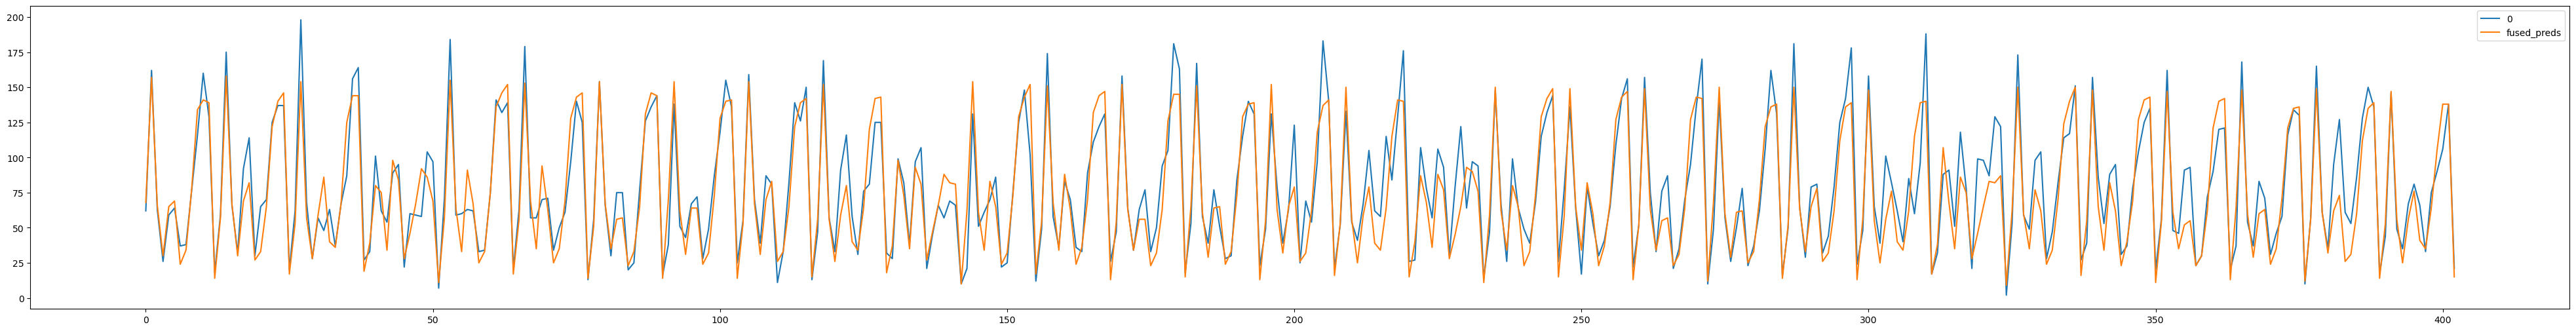

In [230]:
fusing.plot(kind = 'line',figsize =(50,6))
rmse = sqrt(mean_squared_error(fusing[0],fusing['fused_preds']))
print('rmse:',rmse)
#MAPE should be less than 10  ##1.609 <15%
mape = (1/len(fusing))*np.sum(np.abs((fusing[0]-fusing['fused_preds'])/fusing[0]))*100
print('mape:',mape)
wmape = np.sum((fusing[0]/np.sum(fusing[0]))*(np.abs((fusing[0]-fusing['fused_preds'])/fusing[0])))*100
print('wmape:',wmape)
smape = (2/len(fusing))*np.sum(np.abs(fusing[0]-fusing['fused_preds'])/(fusing[0]+fusing['fused_preds']))*100
print('smape:',smape)

In [231]:
print('Mape: ',mean_absolute_percentage_error(fusing[0],fusing['fused_preds']))
print('Mae: ',mean_absolute_error(fusing[0],fusing['fused_preds']))

Mape:  0.20551698867304594
Mae:  13.33002481389578


In [127]:
#fuse_model.save('fused_model.h5')

In [227]:
fuse_model = load_model('fused_model.h5')
##mape = 20.55% epochs = 225, batch_size = 10,lstm 96,54,16layers and output layer

# Prediction using weather data

In [4]:
df1 = pd.read_parquet('kelusankahourly_2022_along with rainfall.parquet')
df1.head(5)

,ETD_DATE,ETD_TD_TIME,DEMAND,RAINFALL
0,2022-01-01,7,28,0.0
1,2022-01-01,8,70,0.0
2,2022-01-01,9,22,0.0
3,2022-01-01,10,14,0.0
4,2022-01-01,11,58,0.0


In [5]:
rf_train,rf_test,demand_train,demand_test = df1[['RAINFALL']].iloc[:4342],df1[['RAINFALL']].iloc[4342:],df1[['DEMAND']].iloc[:4342],df1[['DEMAND']].iloc[4342:]
#hourly_train,hourly_test
print(len(rf_train),len(demand_test))

4342 403


In [6]:
norm1 = MinMaxScaler()
norm1.fit(rf_train)
norm_rf_train = norm1.transform(rf_train)
norm_rf_test = norm1.transform(rf_test)

norm2 = MinMaxScaler()
norm2.fit(demand_train)
norm_dem_train = norm2.transform(demand_train)
norm_dem_test = norm2.transform(demand_test)
len(norm_rf_train)

4342

In [7]:
model4 = Sequential()
model4.add(Dense(128, activation="relu", input_dim=1))
model4.add(Dense(64,activation = 'relu'))
model4.add(Dense(16,activation = 'relu'))
model4.add(Dense(1))

model4.compile(loss="mean_squared_error", optimizer="adam")

model4.fit(norm_rf_train,norm_dem_train, epochs=50)

Epoch 1/50
136/136 [==============================] - 1s 816us/step - loss: 0.0384
Epoch 2/50
136/136 [==============================] - 0s 824us/step - loss: 0.0325
Epoch 3/50
136/136 [==============================] - 0s 787us/step - loss: 0.0325
Epoch 4/50
136/136 [==============================] - 0s 838us/step - loss: 0.0325
Epoch 5/50
136/136 [==============================] - 0s 817us/step - loss: 0.0324
Epoch 6/50
136/136 [==============================] - 0s 824us/step - loss: 0.0324
Epoch 7/50
136/136 [==============================] - 0s 846us/step - loss: 0.0323
Epoch 8/50
136/136 [==============================] - 0s 1ms/step - loss: 0.0325
Epoch 9/50
136/136 [==============================] - 0s 961us/step - loss: 0.0323
Epoch 10/50
136/136 [==============================] - 0s 861us/step - loss: 0.0324
Epoch 11/50
136/136 [==============================] - 0s 868us/step - loss: 0.0325
Epoch 12/50
136/136 [==============================] - 0s 883us/step - loss: 0.0325
Epo

In [8]:
predictions = model4.predict(norm_rf_test)

13/13 [==============================] - 0s 831us/step


In [9]:
predictions = norm2.inverse_transform(predictions)

weather = pd.DataFrame(predictions)
actuals = norm2.inverse_transform(norm_dem_test)
weather['actuals'] = actuals
weather.head()

,0,actuals
0,63.012005,62.0
1,63.012005,162.0
2,63.012005,63.0
3,63.012005,26.0
4,63.012005,59.0


mape: 57.92950239418525
smape: 50.34434623786278


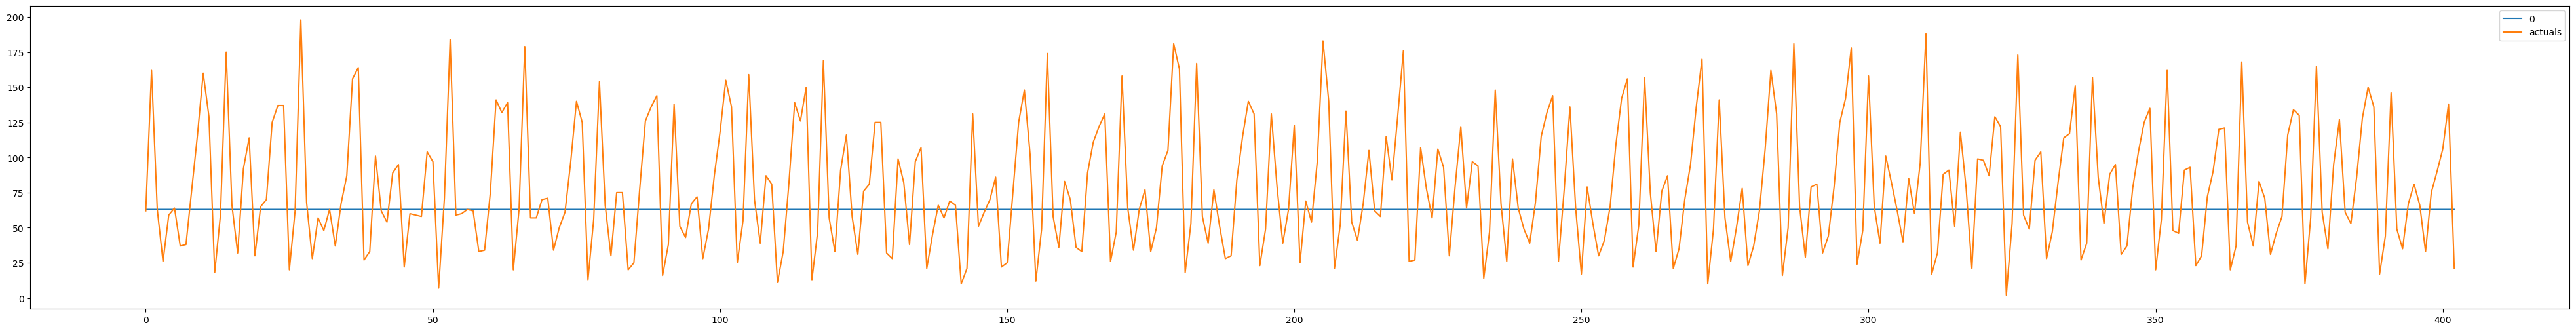

In [12]:
weather.plot(kind = 'line',figsize = (50,6))
mape = (1/len(weather))*np.sum(np.abs((weather[0]-weather['actuals'])/weather[0]))*100
smape = (2/len(weather)*np.sum(np.abs(weather[0]-weather['actuals'])/(weather[0]+weather['actuals'])))*100
print('mape:',mape)
print('smape:',smape)